In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import re
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords') 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from joblib import load, dump

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def check_metrics(history, figure_name):
      train=history.history[f'{figure_name}']
      val = history.history[f'val_{figure_name}']

      epochs = range(1, len(train)+1)
      plt.plot(epochs, train, 'b', label = f'Training {figure_name}')
      plt.plot(epochs, val, label = f'Validation {figure_name}', color = 'green')
      plt.title(f'Training and Validation {figure_name}')
      plt.xlabel('Epochs')
      plt.ylabel(f'{figure_name}')
      plt.legend()
      plt.show()

In [3]:
test=tf.keras.utils.text_dataset_from_directory(r"D:\aclImdb\test")
train=tf.keras.utils.text_dataset_from_directory(r"D:\aclImdb\train")

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [4]:
def extract_rating(filename):
  parts = filename.split('_')
  rating = int(parts[1].split('.')[0])
  return rating

def create_dataframe(folder_path):
  data = []
  for i, subfolder in enumerate(os.listdir(folder_path)):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
      for filename in os.listdir(subfolder_path):
        if filename.endswith(".txt"):
          filepath = os.path.join(subfolder_path, filename)
          with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
          rating = extract_rating(filename)
          data.append({'text': text, 'rating': rating, 'label': i})  
  return pd.DataFrame(data)

folder_path = r"D:\aclImdb\test"
folder_path_2=r"D:\aclImdb\train"
test_df = create_dataframe(folder_path)
train_df=create_dataframe(folder_path_2)

print(test_df)

                                                    text  rating  label
0      Once again Mr. Costner has dragged out a movie...       2      0
1      This is an example of why the majority of acti...       4      0
2      First of all I hate those moronic rappers, who...       1      0
3      Not even the Beatles could write songs everyon...       3      0
4      Brass pictures (movies is not a fitting word f...       3      0
...                                                  ...     ...    ...
24995  I was extraordinarily impressed by this film. ...       8      1
24996  Although I'm not a golf fan, I attended a snea...      10      1
24997  From the start of "The Edge Of Love", the view...       8      1
24998  This movie, with all its complexity and subtle...      10      1
24999  I've seen this story before but my kids haven'...       7      1

[25000 rows x 3 columns]


In [5]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac = 1)
train_df

,text,rating,label
18690,I'll keep this one quite short. I believe that...,8,1
15816,Miss DeCarlo's starring debut has everything t...,10,1
5370,"Curiously, it is Rene Russo's eyes and mouth--...",4,0
14701,This is how I feel about the show.<br /><br />...,7,1
12932,Loved the movie. I even liked most of the acto...,7,1
...,...,...,...
9599,How do you spell washed up fat Italian who can...,2,0
7790,Scary Movie 3 isn't as funny as its predecesso...,4,0
1649,Forbidden Siren is based upon the Siren 2 Play...,2,0
17742,This is one of the few movies released about a...,10,1


In [6]:
def data_processing(text):
      text = text.lower()
      text = re.sub('<br />', '', text)
      text = re.sub(r"https\S+www\S+https\S+", '', text, flags = re.MULTILINE)
      text = re.sub(r'\@w+|\#', '', text)
      text = re.sub(r'^[\w\s]', '', text)
      text_tokens = word_tokenize(text)
      filtered_text = [w for w in text_tokens if not w in stop_words]
      return " ".join(filtered_text)

In [7]:
train_df.text = train_df['text'].apply(data_processing)
test_df.text = test_df['text'].apply(data_processing)
train_df['text']

18690    'll keep one quite short . believe extraordina...
15816    iss decarlo 's starring debut everything write...
5370     uriously , rene russo 's eyes mouth -- buddy g...
14701    feel show.i started watching show reruns 2001....
12932    oved movie . even liked actors . , ms. davis '...
                               ...                        
9599     ow spell washed fat italian barely pull martia...
7790     cary movie 3 n't funny predecessors still funn...
1649     orbidden siren based upon siren 2 playstation ...
17742    one movies released `` '' type situation made ...
20631    ....... playing kaddiddlehopper , col san fern...
Name: text, Length: 25000, dtype: object

In [8]:
duplicated_count = train_df.duplicated().sum()
duplicated_count

98

In [9]:
duplicated_count = test_df.duplicated().sum()
duplicated_count

197

In [10]:
train_df = train_df.drop_duplicates('text')
test_df = test_df.drop_duplicates('text')

In [11]:
X_train = train_df['text']
X_test = test_df['text']
Y_train = train_df['label']
Y_test = test_df['label']
Z_train = train_df['rating']
Z_test = test_df['rating']

In [12]:
vect = TfidfVectorizer()
X_train = vect.fit_transform(train_df['text'])
X_test = vect.transform(test_df['text'])

In [13]:
X_train = X_train[:25000]
X_test =X_test[:25000]
Y_train = Y_train[:25000]
Y_test = Y_test[:25000]
Z_train = Z_train[:25000]
Z_test = Z_test[:25000]

In [14]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [15]:
optimazer = Adam(learning_rate=0.001)

Epoch 1/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 143s 91ms/step - loss: 11.0352 - mse: 11.0352 - val_loss: 4.5584 - val_mse: 4.5584
Epoch 2/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step - loss: 3.4496 - mse: 3.4496 - val_loss: 4.5831 - val_mse: 4.5831
Epoch 3/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 98s 63ms/step - loss: 2.2155 - mse: 2.2155 - val_loss: 5.3379 - val_mse: 5.3379
Epoch 4/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 98s 63ms/step - loss: 1.8004 - mse: 1.8004 - val_loss: 5.0105 - val_mse: 5.0105
Epoch 5/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 98s 63ms/step - loss: 1.4568 - mse: 1.4568 - val_loss: 5.1686 - val_mse: 5.1686
Epoch 6/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 101s 65ms/step - loss: 1.2984 - mse: 1.2984 - val_loss: 5.3671 - val_mse: 5.3671
Epoch 7/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 100s 64ms/step - loss: 1.1625 - mse: 1.1625 - val_loss: 5.5209 - val_mse: 5.5209
Epoch 8/15
1557/1557 ━━━━━━━━━━━━━━━━━━━━ 101s 65ms/step - loss: 1.0642 - mse: 1.0642 - val_loss: 5.1524 - val_mse: 5.1524
Epoch 9/15
1557/15

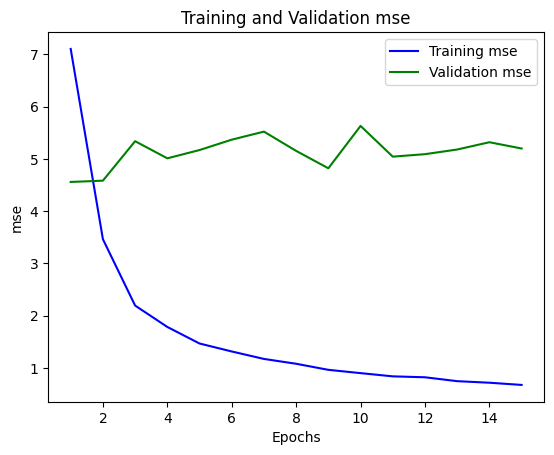

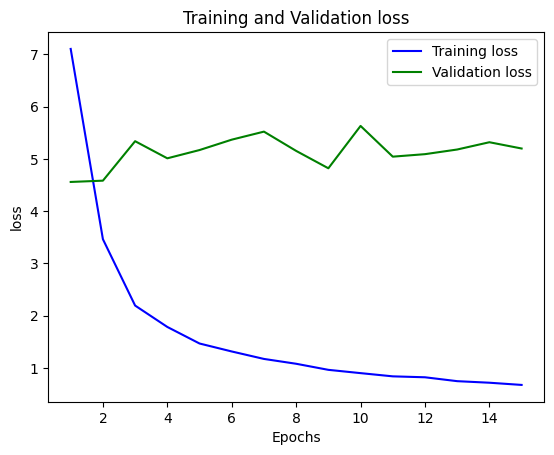

In [16]:
model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=optimazer,  loss='mse',  metrics=['mse'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
history = model.fit(x = X_train, y = Z_train, epochs = 15, batch_size=16, validation_data= (X_test, Z_test ))
check_metrics(history, 'mse')
check_metrics(history, 'loss')

In [17]:
dump(model, 'model.joblib')
dump(vect, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 61s 311ms/step - accuracy: 0.7480 - loss: 0.6417 - val_accuracy: 0.8651 - val_loss: 0.4484
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9043 - loss: 0.3641 - val_accuracy: 0.8894 - val_loss: 0.2974
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9331 - loss: 0.2059 - val_accuracy: 0.8863 - val_loss: 0.2745
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9573 - loss: 0.1402 - val_accuracy: 0.8827 - val_loss: 0.2871
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9697 - loss: 0.1056 - val_accuracy: 0.8769 - val_loss: 0.3114
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9800 - loss: 0.0768 - val_accuracy: 0.8750 - val_loss: 0.3302
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9862 - loss: 0.0565 - val_accuracy: 0.8696 - val_loss: 0.3620
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9892 - loss: 0.0445 - val_ac

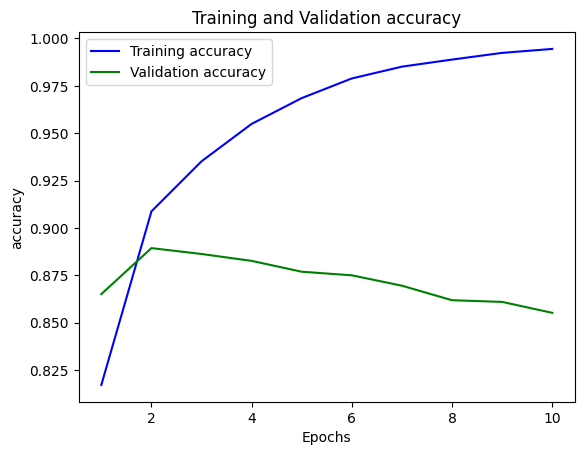

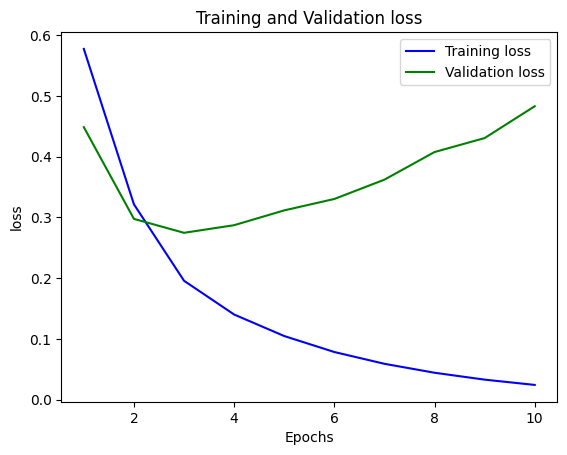

In [18]:
model2 = Sequential()
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop',  loss='binary_crossentropy',  metrics=['accuracy'])
history2 = model2.fit(x = X_train, y = Y_train, epochs = 10, batch_size= 128, validation_data= (X_test, Y_test ))
check_metrics(history2, 'accuracy')
check_metrics(history2, 'loss')
